In [46]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plot_format = {
    0  : ['mediumseagreen', '-'],
    1  : ['blue', ':'],
    2  : ['green', '-.'],
    3  : ['black', '--'],
    4  : ['hotpink', '-'],
    5  : ['orange', ':'],
    6  : ['brown', '-.'],
    7  : ['purple', '--'],
    8  : ['aquamarine', '-'],
    9  : ['red', ':'],
    10 : ['lawngreen', '-.'],
    11 : ['burlywood', '--'],
    12 : ['cadetblue', '-'],
    13 : ['darkgreen', ':'],
    14 : ['coral', '-.'],
    15 : ['cyan', '--'],
}

def find_pixel(initial_threshold_values):
    all_rising_edges = np.zeros((324,324), dtype=int)
    cols = initial_threshold_values.shape[1]
    rows = initial_threshold_values.shape[2]
    for c in range(cols):
        for r in range(rows):
            rising_edge = np.where(np.diff(initial_threshold_values[:,c,r] > 50))[0]
            if len(rising_edge) != 0: 
                all_rising_edges[c,r] = rising_edge[0]
            # Set a large difference so it is easy to remove invalid values
            else:
                all_rising_edges[c,r]  = 10000
    return all_rising_edges

# Define the Gaussian function
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev) ** 2)

In [47]:
def static_trim(directory):
    files = [x for x in os.listdir(directory)]
    initial_threshold_values = []
    x = []
    for i, opf in enumerate(files):
        name = opf.split('_')
        x.append(int(name[0][1:]) - int(name[1][1:]))
        data = np.loadtxt(f'{directory}/{opf}', delimiter=',', dtype=np.uint8, converters=float, comments='#')
        initial_threshold_values.append(data)
    x = np.array(x)
    initial_threshold_values = np.array(initial_threshold_values)
    # Create an array for storing the counts of x value
    counts = np.zeros((x.shape))
    rising_edge_indices = find_pixel(initial_threshold_values)
    # Get the values of each rising edge and the counts
    values, unique_counts = np.unique(rising_edge_indices,return_counts=True)
    values, unique_counts = values[:-1], unique_counts[:-1] # Remove invalid values
    # Set the counts for each x value, some values do not appear so we cant just use the unique results
    counts[values] = unique_counts

    # Fit the data to the Gaussian function
    popt, pcov = curve_fit(gaussian, x, counts, p0=[max(counts), np.mean(x), np.std(x)])

    # Extract the optimized parameters
    amplitude, mean, stddev = popt

    # Generate the fitted curve
    x_fit = np.linspace(min(x), max(x), 1000)
    y_fit = gaussian(x_fit, *popt)

    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    axs[0].plot(x , initial_threshold_values[:,0,0], 'b+:')
    axs[0].set(xlabel='Voltage Threshold (mV)', ylabel='Digital Signal', title='Pixel : 0,0')
    axs[1].plot(x, counts,'b+:',label='Data')
    axs[1].plot(x_fit, y_fit, 'r', label=f'Mean : {mean:.2f} Std Dev : {stddev:.2f}', alpha=0.5)
    axs[1].plot(mean, amplitude, 'ro')
    axs[1].plot([mean - stddev, mean + stddev], [amplitude * 0.4, amplitude * 0.4], 'r:')
    axs[1].legend()
    axs[1].set(xlabel='Voltage Threshold (mV)', ylabel='Pixel Population', title='Mean Rising Edge Fit')

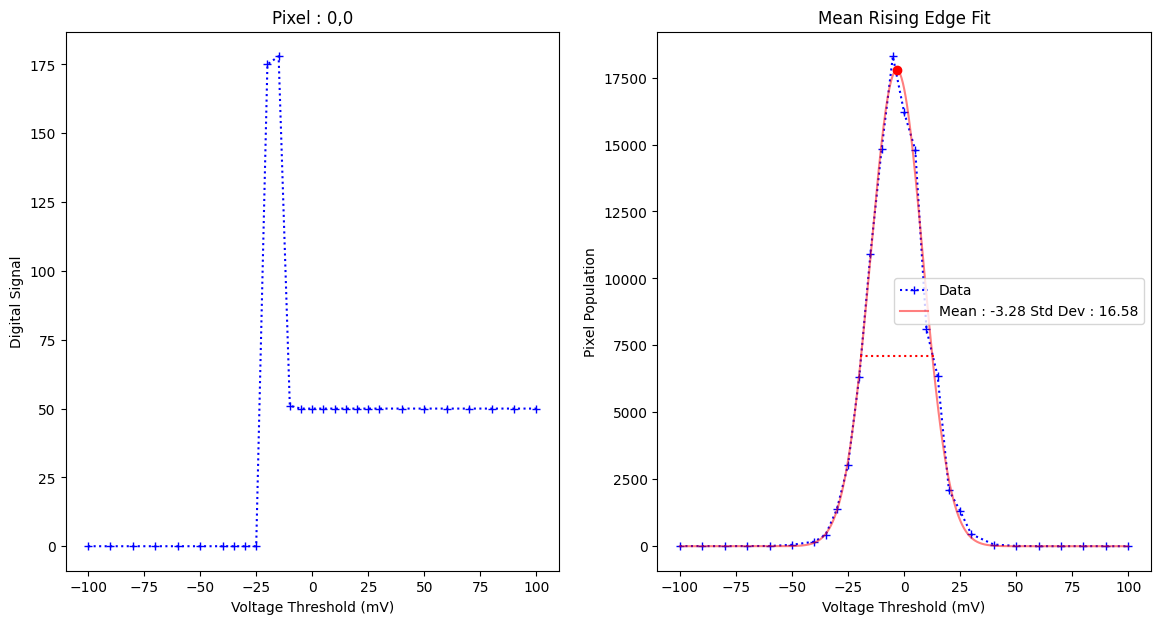

In [48]:
# Determine mean rising edge from a trim value of 15 for all pixels
directory = f'C:/Users/chem-chem1612/Documents/PIMMS-Calibration/10-06-24/15'
static_trim(directory)

In [85]:
mean = -3.28
directory = f'C:/Users/chem-chem1612/Documents/PIMMS-Calibration/10-06-24/'

pixels = {}
for a in range(324):
    for b in range(324):
        pixels[f'{a},{b}'] = {x : 0 for x in range(4,15,1)}
for i in range(4,15,1):
    files = [x for x in os.listdir(f'{directory}/{i}')]
    data_stacked = []
    names = []
    for file in files:        
        name = file.split('_')
        names.append(int(name[0][1:]) - int(name[1][1:]))
        data = np.loadtxt(f'{directory}/{i}/{file}', delimiter=',', dtype=np.uint8, converters=float, comments='#')
        data_stacked.append(data)
    data_stacked = np.array(data_stacked)
    for a in range(324):
        for b in range(324):
            rising_edge = np.where(np.diff(data_stacked[:,a,b] > 50))[0]
            if len(rising_edge) != 0: 
                pixels[f'{a},{b}'][i] = names[rising_edge[0]]

trim_values = np.zeros((324,324), dtype=int)
for a in range(324):
    for b in range(324):
        lowest = 99
        for trim in range(4,15,1):
            difference = abs(mean - pixels[f'{a},{b}'][trim])
            if difference < lowest:
                lowest = difference
                trim_values[a][b] = trim
np.savetxt(f"{directory}/trim.csv", trim_values, delimiter=",", fmt='%d')

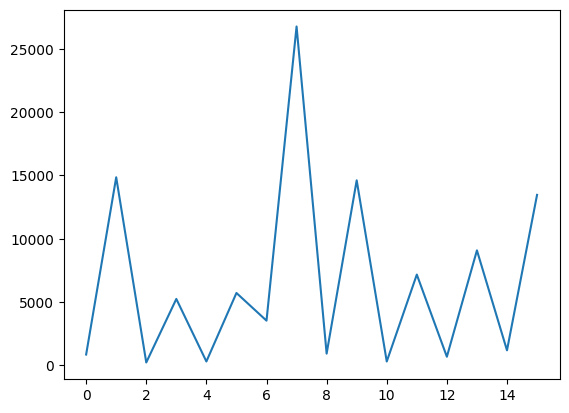

In [42]:
# Plot how often a trim value has been used in a calibration
file_arr = np.loadtxt('Q:/Cameras/PImMS/Trim_Files/11.csv',delimiter=',')
value, counts = np.unique(file_arr, return_counts=True)
plt.plot(value, counts)
# 0, 2, 8, 10